# Lidar depression finding on the plateau

Most of the problems are getting the areas lined up, with the direction of y plotting up or down.  

In [678]:
# The good slick way to do this using pandas to autoload tiff/csv files 
# adds to the confusion and doesn't help out, so we load the file as 
# ascii brute force into numpy.  Even then, the x and y (column and row) are
# confusing.
import numpy


fl = open("als_dgm_1m.txt").readlines()

for l in fl[:6]:
    print(l.strip())
ncols = int(fl[0].split()[1])
nrows = int(fl[1].split()[1])
xllcorner = float(fl[2].split()[1].replace(",", "."))
yllcorner = float(fl[3].split()[1].replace(",", "."))
print(xllcorner, yllcorner, nrows)

# the -1 on the shape are to strip out the -9999.0 values
ny = len(fl)-6
nx = len(fl[6].split())
assert ny == nrows and nx == ncols
mg, d = numpy.meshgrid(numpy.linspace(0, 1, nx-1), numpy.linspace(0, 1, ny-1))
print(nx, ny)  
for i in range(ny-1):
    l = fl[6+i].split()
    for j in range(nx-1):
        s = float(l[j].replace(",", "."))
        mg[i][j] = s
assert nx == ncols and ny == nrows

ncols         801
nrows         1251
xllcorner     411099,5
yllcorner     5282599,5
cellsize      1
NODATA_value  -9999
411099.5 5282599.5 1251
801 1251


In [644]:
import scipy.ndimage.filters
import skimage.measure


In [661]:
gaussfilterrad = 7
contourdepth = -2
maxdiamallowed = 10  # or could use eccentricity

fmg = scipy.ndimage.gaussian_filter(mg, gaussfilterrad)
lmg = mg - fmg
llmg = skimage.measure.label(lmg<contourdepth, connectivity=2)

rp = skimage.measure.regionprops(llmg, intensity_image=lmg)
print("found %d regions at depth %d" % (len(rp), contourdepth))

rp.sort(key=lambda X: X.min_intensity)


found 2281 regions at depth -2


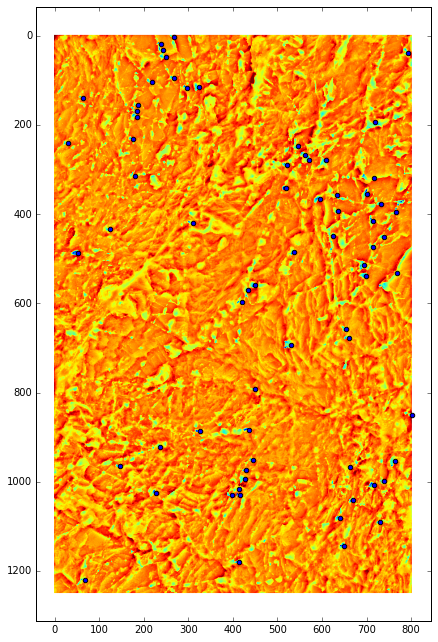

In [662]:
from matplotlib import pyplot as plt
%matplotlib inline

# plot the regions offset so we can see them
plt.figure(figsize=(11,11))
plt.imshow(lmg, vmin=-15, vmax=5)
print(rp[0])
plt.scatter([r.centroid[1]+7 for r in rp[:70]], [r.centroid[0] for r in rp[:70]])
#plt.plot([r.min_intensity  for r in rp])
#plt.plot([r.area  for r in rp])


In [789]:
# this contour slices deeper within the areas that are too large until they fragment into smaller areas
# (non-recursive for simplicity)
rpS = [ ]
for r in rp:
    if r.major_axis_length > maxdiamallowed:
        for i in range(40):
            contourdepthI = contourdepth - i*0.25
            llmg2 = skimage.measure.label(r.intensity_image<contourdepthI, connectivity=2)
            rp2 = skimage.measure.regionprops(llmg2, intensity_image=r.intensity_image)
            if len(rp2) == 0:
                break
            if max(r2.major_axis_length  for r2 in rp2) <= maxdiamallowed:
                break
        else:
            print("ran out of depths")
        for r2 in rp2:
            r2i = r2.intensity_image
            j, i = numpy.unravel_index(r2i.argmin(), r2i.shape)
            #print(lmg[r.bbox[0]+r2.bbox[0]+j, r.bbox[1]+r2.bbox[1]+i]- r2.min_intensity)
            rpS.append(((r.bbox[1], r.bbox[0]), r2, (r.bbox[1]+r2.bbox[1]+i, r.bbox[0]+r2.bbox[0]+j)))
    else:
        ri = r.intensity_image
        j, i = numpy.unravel_index(ri.argmin(), ri.shape)
        #print(lmg[r.bbox[0]+j,r.bbox[1]+i]- r.min_intensity)
        rpS.append(((0,0), r, (r.bbox[1]+i, r.bbox[0]+j)))

rpS.sort(key=lambda X: X[1].min_intensity)
print("Total pits of diameter less than %f is %d" % (maxdiamallowed, len(rpS)))

# proof that we have the coordinates of the bottoms of these pits
for r in rpS[:20]:
    assert (r[1].min_intensity == lmg[r[2][1], r[2][0]])  # xy flipped for numpy access

rpSN = [ (r[2][0], r[2][1], mg[r[2][1], r[2][0]], i)  for i, r in enumerate(rpS) ]

Total pits of diameter less than 10.000000 is 2824


In [681]:
# now find all the entrances in the file and relate them into the bitmap
# note the nrows-y flipping
import sys
sys.path.append("/home/goatchurch/caving/survexprocessing")
import parse3ddmp
d3d = parse3ddmp.DMP3d(open("/home/goatchurch/caving/expoloser/all.dmp"))
rents = [ ]
for p, name, category in d3d.nodes:
    if "ENTRANCE" in category:
        rents.append((p[0]-xllcorner, nrows-(p[1]-yllcorner), p[2], name))


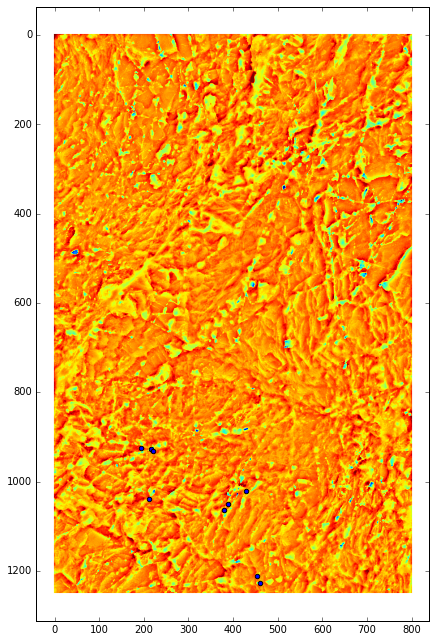

In [689]:
# check we are good at locating the entrances (the 204 ones should be in lower half)
plt.figure(figsize=(11,11))
plt.imshow(lmg, vmin=-15, vmax=5)
rents204 = [ r  for r in rents  if "204" in r[3] ]
plt.scatter([r[0] for r in rents204], [r[1]  for r in rents204])



In [791]:
# find closest pits for each entrance
import math
def distenthole(e, r):
    return math.sqrt((e[0]-r[0])**2 + (e[1]-r[1])**2)

for e in rents204:
    r = min(rpSN, key=lambda X: distenthole(e, X))
    print(e[3], distenthole(e, r))

    

p204c 0.8920201791016108
p204h 3.8525316349762337
t204b 3.314121301703438
p204f 3.885151219597174
p204i 7.312079047742887
p204g 9.613376098236852
p204e 7.4912282040635345
t204d 6.464503074409845
p204a 5.703069349046508


p204a dist 5.703069349046508 terrain min 1816.15 max 1832.2
p204e dist 7.4912282040635345 terrain min 1809.6 max 1833.36

I don't like the location of 204e here.  Can someone visit the location
and verify the terrain is as shown in relief for the surrounding 50m?
The 204a location is however in a better place than the official location


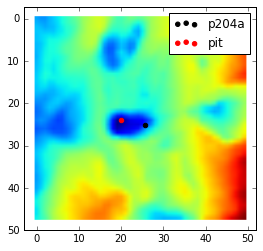

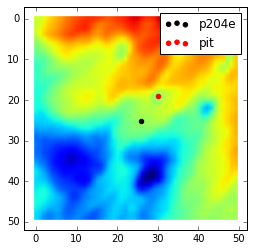

In [792]:
# We need to understand the differences on p204a which should be right close to this amazing crater

d = 25
def plotsurround(e):
    ix, iy = int(e[0]), int(e[1])
    submg = mg[iy-d:iy+d,ix-d:ix+d]
    r = min(rpSN, key=lambda X: distenthole(e, X))
    print(e[3], "dist", distenthole(e, r), "terrain min", submg.min(), "max", submg.max())
    #plt.figure(figsize=(6,6))

    plt.figure()
    plt.imshow(submg)
    #rents204 = [ r  for r in rents  if "204" in r[3] ]

    plt.scatter([e[0]-(ix-d)], [e[1]-(iy-d)], color="black", label=e[3])
    plt.scatter([r[0]-(ix-d)], [r[1]-(iy-d)], color="r", label="pit")
    plt.legend()

e = [e  for e in rents204  if "204a" in e[3]][0]
plotsurround(e)

e = [e  for e in rents204  if "204e" in e[3]][0]
plotsurround(e)

print("\nI don't like the location of 204e here.  Can someone visit the location")
print("and verify the terrain is as shown in relief for the surrounding 50m?")
print("The 204a location is however in a better place than the official location")

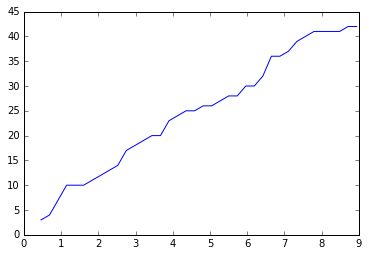

In [793]:
# Find a cutoff level for the entrance holes
d = 5
rentspage = [ r  for r in rents  if d<r[0]<ncols-d and d<r[1]<nrows-d ]

pitmatchdistance = 8

holematches = [ ]
for i in range(50, 1000, 25):
    matchcount = sum(1  for e in rentspage  if min(distenthole(e, r)  for r in rpSN[:i]) < pitmatchdistance)
    holematches.append((i, matchcount))
    #print(holematches[-1])
#print(e[3], "dist", distenthole(e, r), "terrain min", submg.min(), "max", submg.max())
plt.plot([h[0]/len(rentspage)  for h in holematches], [h[1]  for h in holematches])

# we pick the 425 cut off of pit qualities which matches 25% of the entrances
pitnumber = 425

In [796]:
rpSEnt = [ ]
rpSLiso = [ ]
rpSLisoSpaced = [ ]
for r in rpSN[:pitnumber]:
    if min(distenthole(e, r)  for e in rents) < pitmatchdistance:
        rpSEnt.append(r)
    else:
        rpSLiso.append(r)
        if not rpSLisoSpaced or min(distenthole(r1, r)  for r1 in rpSLisoSpaced) > pitmatchdistance:
            rpSLisoSpaced.append(r)

print("Beginning with %d pits, then %d more than %f metres from a known entrance (%f%% of entrances), then %d spaced by more than that between each" % (pitnumber, len(rpSLiso), pitmatchdistance, len(rpSEnt)/len(rentspage)*100, len(rpSLisoSpaced)))


Beginning with 425 pits, then 404 more than 8.000000 metres from a known entrance (19.266055% of entrances), then 356 spaced by more than that between each


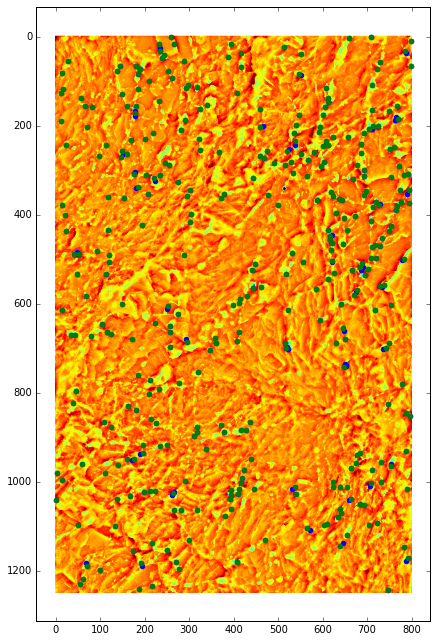

In [797]:
plt.figure(figsize=(11,11))
plt.imshow(lmg, vmin=-15, vmax=5)
rents204 = [ r  for r in rents  if "204" in r[3] ]
plt.scatter([r[0] for r in rpSLiso], [r[1]  for r in rpSLiso], color="blue")
plt.scatter([r[0] for r in rpSLisoSpaced], [r[1]  for r in rpSLisoSpaced], color="green")


In [799]:
# Now we build the output GPX file that we use for the searching
import pyproj
import gpxpy.gpx

prj = pyproj.Proj("+proj=utm +zone=33 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
gpx = gpxpy.gpx.GPX()

for r in rentspage:
    p = prj(xllcorner+r[0], yllcorner + nrows-r[1], inverse=True)
    gpx.waypoints.append(gpxpy.gpx.GPXWaypoint(latitude=p[1], longitude=p[0], elevation=r[2], name=r[3], symbol="Circle, Red"))
        
for r in rpSLisoSpaced:
    p = prj(xllcorner+r[0], yllcorner + nrows-r[1], inverse=True)
    gpx.waypoints.append(gpxpy.gpx.GPXWaypoint(latitude=p[1], longitude=p[0], elevation=r[2], name="N%d"%r[3], symbol="Circle, Green"))

fout = open("pittargets350.gpx", "w")
fout.write(gpx.to_xml())
fout.close()



In [437]:
r = rp[1]
ri = r.intensity_image
j, i = numpy.unravel_index(ri.argmin(), ri.shape)
r.min_intensity, r.bbox, i, j, lmg[369+3,731+45]

#45 3 -17.5747009752
#411513.5 5283065.5
#(0, 369, 45) (0, 731, 3)
# (-17.574700975217866, (369, 731, 425, 784), 45, 3, -17.574700975217866)

(-17.574700975217866, (369, 731, 425, 784), 45, 3, -17.574700975217866)

In [447]:
llmg2 = skimage.measure.label(r.intensity_image<-10, connectivity=2)
rp2 = skimage.measure.regionprops(llmg2, intensity_image=r.intensity_image)

max(r2.major_axis_length  for r2 in rp2)
r2 = rp2[0]
j, i = numpy.unravel_index(r2.intensity_image.argmin(), r2.intensity_image.shape)
((r.bbox[1], r.bbox[0]), r2.bbox, r2.min_intensity, i, j)

#                break
#len(rp2)


((731, 369), (1, 43, 5, 51), -17.574700975217866, 2, 2)

In [471]:
rpS.sort(key=lambda X: X[1].min_intensity)
plt.figure(figsize=(21,21))
#plt.imshow(lmg)


1 1 -2.5021991698
411574.5 5283825.5
(0, 474, 1) (0, 24, 1) 475 25


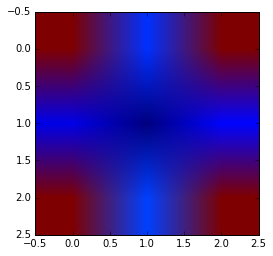

In [557]:
# use the following to find the minimum value in the area
(x0, y0), rp, (xi, yi) = rpS[1982]
rpi = rp.intensity_image
j, i = numpy.unravel_index(rpi.argmin(), rpi.shape)
print(i, j, rpi[j][i])
#print(rpi)
plt.imshow(rpi)
x, y = rp.bbox[1], rp.bbox[0]

depressionpts = [ ]
p = prj(xllcorner+xi, yllcorner+nrows-(yi), inverse=True)
depressionpts.append(gpxpy.gpx.GPXWaypoint(latitude=p[1], longitude=p[0], elevation=rp.min_intensity, name="hole", symbol="Circle, Red"))
print(xllcorner+x0+x+i, yllcorner+nrows-(y0+y+j))
print((x0,x,i), (y0,y,j), xi, yi)
#45 3 -17.5747009752
#411513.5 5283065.5
#(0, 369, 45) (0, 731, 3)


for i in [0, rp.bbox[3]-rp.bbox[1]]:
    for j in [0, rp.bbox[2]-rp.bbox[0]]:
        p = prj(xllcorner+x0+x+i, yllcorner+nrows-(y0+y+j), inverse=True)
        depressionpts.append(gpxpy.gpx.GPXWaypoint(latitude=p[1], longitude=p[0], elevation=rp.min_intensity, name="i%dj%d"%(i,j), symbol="Circle, Red"))


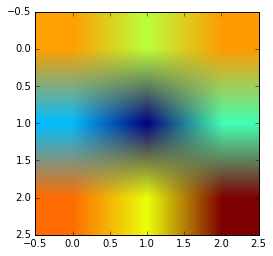

In [558]:
plt.imshow(lmg[rp.bbox[0]:rp.bbox[2],rp.bbox[1]:rp.bbox[3]])


In [567]:
import pyproj
prj = pyproj.Proj("+proj=utm +zone=33 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
dnodes = [ ]
n = 0
for (x0, y0), rp, (xi, yi) in rpS:
    rpi = rp.intensity_image
    j, i = numpy.unravel_index(rpi.argmin(), rpi.shape)
    x, y = rp.bbox[1], rp.bbox[0]
    dnodes.append((xllcorner+xi, yllcorner+nrows-yi, mg[yi,xi], n))
    n += 1
    

print(len(dnodes))
import math
def dist(dnode, enode):
    return math.sqrt((enode[0][0]-dnode[0])**2 + (enode[0][1]-dnode[1])**2)
#dnodes = [d  for d in dnodes  if min(dist(d, X)  for X in enodes)<8]

#dnodes = [k  for k in dnodes  if abs(k[1]-yllcorner)<100]
print(len(dnodes))
dnodes = dnodes[:20]
#dnodes = [(xllcorner+482, yllcorner+nrows-1224,1800)]

depressionpts = [ ]
for s0 in dnodes:
    p = prj(s0[0], s0[1], inverse=True)
    depressionpts.append(gpxpy.gpx.GPXWaypoint(latitude=p[1], longitude=p[0], elevation=s0[2], name="N%d"%s0[3], symbol="Circle, Green"))
len(depressionpts)

2824
2824


20

In [561]:
import math
def dist(dnode, enode):
    return math.sqrt((enode[0][0]-dnode[0])**2 + (enode[0][1]-dnode[1])**2)
for d in dnodes[:10]:
    X = min(enodes, key=lambda X:dist(d, X))
    print(dist(d, X), d, X)
    
    

3.8179182808173477 (411763.5, 5283567.5, 1875.26, 60) (P3(411767.04, 5283568.93, 1925.8), 'p2012-dd-03')
4.7040833325067855 (411803.5, 5282806.5, 1871.55, 88) (P3(411799.72, 5282809.3, 1906.81), 'gps02.p2002-ad-01')
14.220284807047351 (411775.5, 5283557.5, 1875.28, 95) (P3(411767.04, 5283568.93, 1925.8), 'p2012-dd-03')
3.9200127550068076 (411319.5, 5282915.5, 1810.8800000000001, 123) (P3(411319.51, 5282919.42, 1833.36), 'p204i')
8.619657765887865 (411512.5, 5283262.5, 1827.3199999999999, 147) (P3(411503.97, 5283261.26, 1866.51), '2012-ns-01.2012-ns-01-tag')
8.722946749958991 (411654.5, 5283105.5, 1865.25, 151) (P3(411647.07, 5283100.93, 1919.81), 'p2012-hw-02')
11.333018132908308 (411260.5, 5282755.5, 1843.8599999999999, 189) (P3(411250.52, 5282760.87, 1781.07), 'p245')
12.747176158088585 (411637.5, 5283610.5, 1870.05, 203) (P3(411643.02, 5283599.01, 1916.8), 'p2012-ns-06')
8.96621436279752 (411260.5, 5282863.5, 1818.47, 209) (P3(411255.17, 5282870.71, 1798.59), 't251')
6.1583276953242

In [568]:
import gpxpy.gpx

gpx = gpxpy.gpx.GPX()

gpx.waypoints.extend(depressionpts[:])
gpx.waypoints.extend(entwaypoints)


fout = open("test20.gpx", "w")
fout.write(gpx.to_xml())
fout.close()




In [239]:
#help(gpxpy.gpx.GPXTrackPoint)



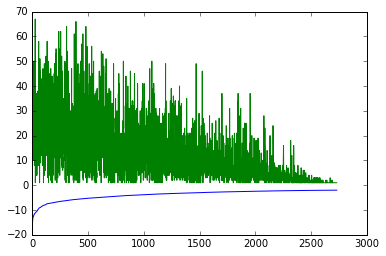

In [167]:
# Now we have a heck of a lot of areas.  
# We need to sort them by quality and match them against the known entrances
# until we can get those that we match in the front end of this ordered list

rpS.sort(key=lambda X:X[1].min_intensity)

plt.plot([r[1].min_intensity  for r in rpS])
plt.plot([r[1].area  for r in rpS])


-11.259426784539301

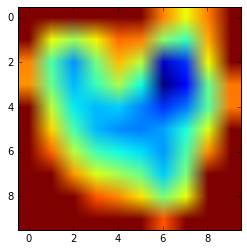

In [169]:
r = max(rpS, key=lambda X:X[1].area)
plt.imshow(r[1].intensity_image)
r[1].min_intensity




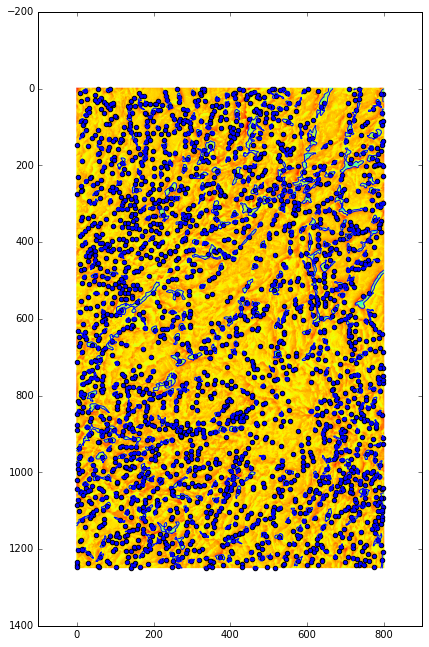

In [117]:
s = skimage.measure.find_contours(lmg, -2)
plt.figure(figsize=(11,11))
for ss in s:
    plt.plot([t[1] for t in ss], [t[0] for t in ss], color="b")
len(s)

plt.imshow(lmg)
plt.scatter([r.centroid[1] for r in rp], [r.centroid[0] for r in rp]) 


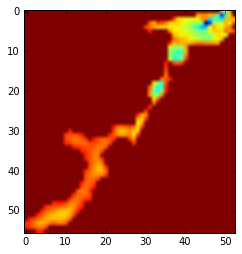

In [137]:
r = rp[1]
plt.imshow(r.intensity_image)
r.major_axis_length
llmg2 = skimage.measure.label(r.intensity_image<-3, connectivity=2)
rp2 = skimage.measure.regionprops(llmg2, intensity_image=r.intensity_image)



[20.324030044678285,
 5.325521087973104,
 9.906841827384923,
 0.0,
 4.843508650621465,
 0.0,
 11.119599145773583]

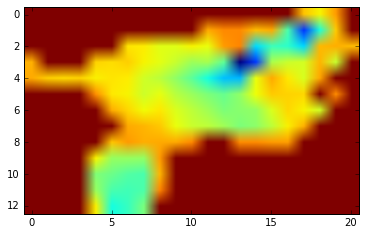

In [149]:
llmg2 = skimage.measure.label(r.intensity_image<-4, connectivity=2)
rp2 = skimage.measure.regionprops(llmg2, intensity_image=r.intensity_image)
plt.imshow(rp2[0].intensity_image)
[r.major_axis_length  for r in rp2]




In [153]:
rp2[3].area

1

In [108]:
llmg = skimage.measure.label(lmg<-2, connectivity=2)
rp = skimage.measure.regionprops(llmg, intensity_image=lmg)
print(len(rp))
r = rp[10]
#help(r)
r.filled_area
r.moments
#help(skimage.measure.regionprops)
dir(r)
r.area

2281


42

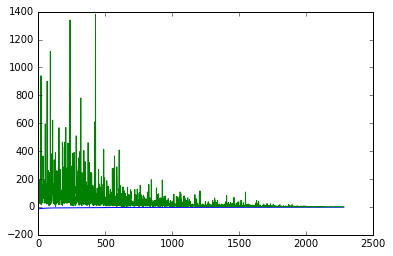

In [110]:
llmg = skimage.measure.label(lmg<-2, connectivity=2)
rp = skimage.measure.regionprops(llmg, intensity_image=lmg)
#rp[-1].min_intensity


In [118]:
rp.sort(key=lambda X:X.min_intensity)
r = rp[0]
r.min_intensity, r.max_intensity
r.bbox
#r.image
#dir(r)
help(r)

#plt.scatter([r.centroid[0] for r in rp], [r.centroid[1] for r in rp]) 

Help on _RegionProperties in module skimage.measure._regionprops object:

class _RegionProperties(builtins.object)
 |  Please refer to `skimage.measure.regionprops` for more information
 |  on the available region properties.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, slice, label, label_image, intensity_image, cache_active)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  area
 |      Number of pixels of region.
 |  
 |  bbox
 |      Bounding box ``(min_row, min_col, max_row, max_col)``.
 |      Pixels belonging to the bounding box are in the half-open interval
 |     

(97, 565, 300, 636)
19.9350388046
(338, 606, 371, 658)
13.2656445256
(772, 266, 793, 293)
12.441562068
(1194, 17, 1223, 42)
8.85568538991
(0, 793, 35, 800)
11.3398093843
(956, 476, 967, 492)
8.4236038696
(754, 517, 767, 529)
6.65667612745
(1134, 59, 1143, 70)
4.2811320659
(1182, 115, 1188, 123)
6.74113988823
(1226, 315, 1232, 322)
3.25930576443


(559, (191, 525, 232, 563))

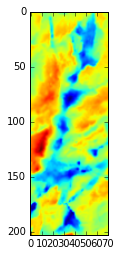

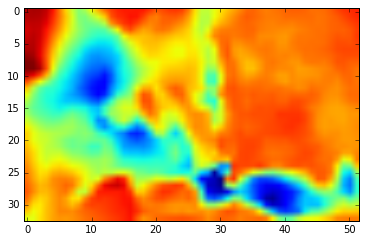

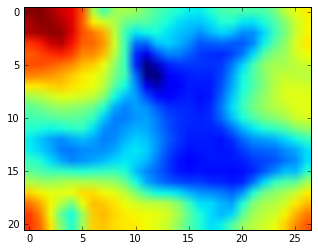

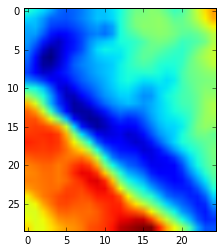

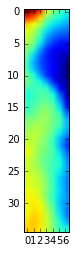

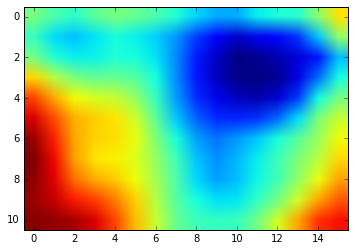

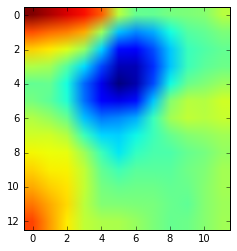

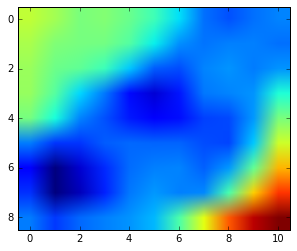

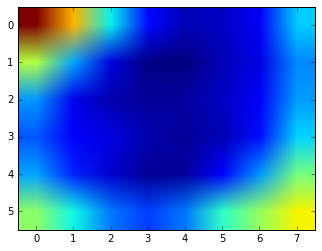

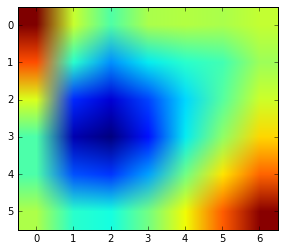

In [49]:


rp = [r  for r in rp  if r.filled_area>25]
rp.sort(key=lambda X:X.filled_area)
#plt.imshow(rp[-10].filled_image)
e = 0
for i in (int(len(rp)-1 - len(rp)*(x/10))  for x in range(10)):
    plt.figure(dpi=50)
    k = rp[i].bbox
    smg = lmg[k[0]-e:k[2]+e, k[1]-e:k[3]+e]
    print(k)
    print(smg.max()-smg.min())
    plt.imshow(smg)

len(rp), rp[-52].bbox

In [52]:
r = rp[50]
#help(r)
r.centroid

(809.35483870967744, 189.03225806451613)

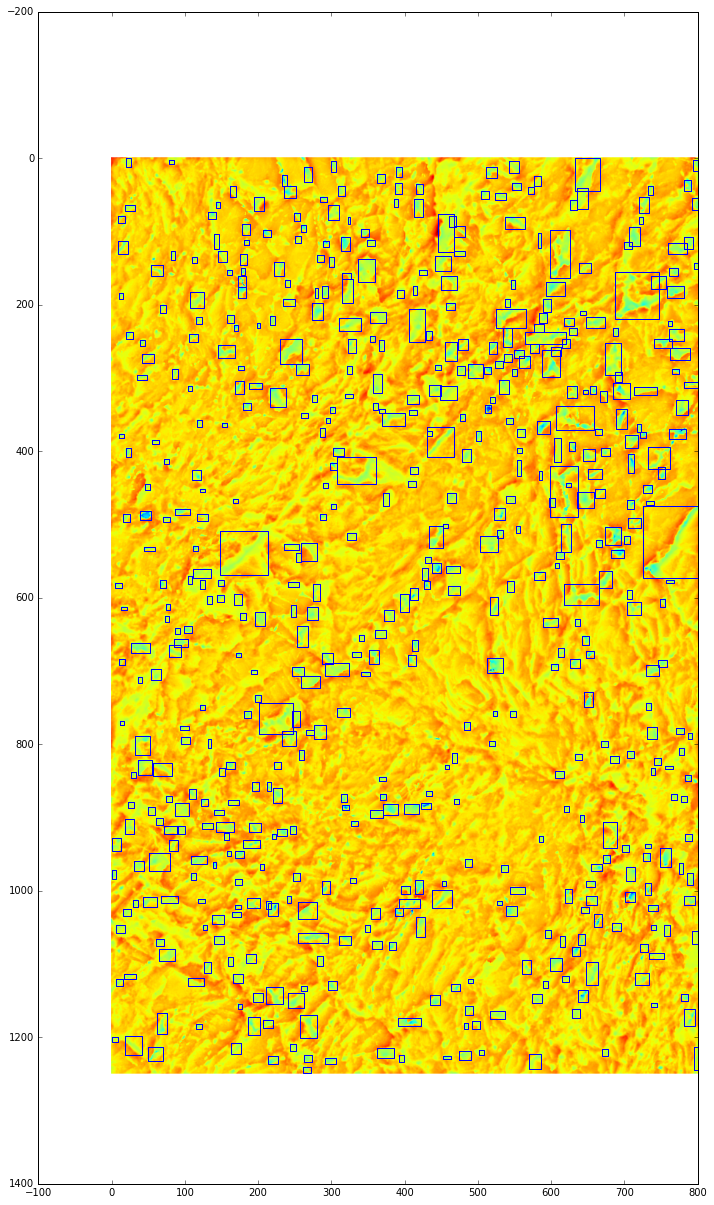

In [127]:
plt.figure(figsize=(21,21))
plt.imshow(lmg)
for r in rp:
    c, a, d, b = r.bbox
    plt.plot([a,a,b,b,a], [c,d,d,c,c], color="b")


In [16]:
import gpxpy


In [43]:
import gpxpy.gpx

gpx = gpxpy.gpx.GPX()

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:
gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(2.1234, 5.1234, elevation=1234, name="hithere"))
gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(2.1235, 5.1235, elevation=1235))
g = gpxpy.gpx.GPXTrackPoint(2.1236, 5.1236, elevation=1236)
g.geoid_height = 99.
gpx_segment.points.append(g)

# You can add routes and waypoints, too...

#print()'Created GPX:', gpx.to_xml())


In [44]:
print(gpx.to_xml())


<?xml version="1.0" encoding="UTF-8"?>
<gpx xsi:schemaLocation="http://www.topografix.com/GPX/1/0 http://www.topografix.com/GPX/1/0/gpx.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://www.topografix.com/GPX/1/0" version="1.0" creator="gpx.py -- https://github.com/tkrajina/gpxpy">
<trk>
<trkseg>
<trkpt lat="2.1234" lon="5.1234">
<ele>1234</ele>
<name>hithere</name></trkpt>
<trkpt lat="2.1235" lon="5.1235">
<ele>1235</ele></trkpt>
<trkpt lat="2.1236" lon="5.1236">
<ele>1236</ele>
<geoidheight>99.0</geoidheight></trkpt></trkseg></trk></gpx>


In [42]:

print(g.geoid_height)

    

99.0


In [26]:
help(gpxpy.gpx.GPXTrackPoint)

Help on class GPXTrackPoint in module gpxpy.gpx:

class GPXTrackPoint(gpxpy.geo.Location)
 |  Generic geographical location
 |  
 |  Method resolution order:
 |      GPXTrackPoint
 |      gpxpy.geo.Location
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __hash__(self)
 |      Return hash(self).
 |  
 |  __init__(self, latitude=None, longitude=None, elevation=None, time=None, symbol=None, comment=None, horizontal_dilution=None, vertical_dilution=None, position_dilution=None, speed=None, name=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  adjust_time(self, delta)
 |      Adjusts the time of the point by the specified delta
 |      
 |      Parameters
 |      ----------
 |      delta : datetime.timedelta
 |          Positive time delta will adjust time into the future
 |          Negative time delta will adjust time into the past
 |  
